<a href="https://colab.research.google.com/github/Nithin-47/Neural_Net/blob/main/Micrograd_with_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import random
import math

In [ ]:
# Defining Value nodes in the micrograd

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other), '+')

    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0*out.grad
    out._backward = _backward

    return out

  def __radd__(self,other):
    return self+other

  def __neg__(self,other):
    return self*-1

  def __sub__(self,other):
    return self + (-other)

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data,(self,other), '*')

    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward

    return out


  def __rmul__(self,other):
    return self*other



  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),'exp')

    def _backward():
      self.grad += out.data*out.grad
    out._backward = _backward

    return out

  def __pow__(self,other):
    assert isinstance(other,(int,float)),"only support int/float powers"
    out = Value(self.data**other,(self,),f'**{other}')

    def _backward():
      self.grad += other*(self.data**(other-1))*out.grad
    out._backward = _backward

    return out


  def __truediv__(self,other):
    return self*other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t,(self,),'tanh')

    def _backward():
      self.grad += (1 - t**2)*out.grad
    out._backward = _backward


    return out

  def backward(self):

    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


# For Ease of Visualizing

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)

  build(root)

  return nodes, edges



def draw_dot(root):

  dot = Digraph(format="svg", graph_attr={"rankdir":"LR"}) #LR = left to Right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it

    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }"% (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is a result of some op, create an op node for it
      dot.node(name= uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1,n2 in edges:
    # Connect n1 to op node of n2
      dot.edge(str(id(n1)),str(id(n2)) + n2._op)


  return dot


In [ ]:
# Just for viewing Pytorch's autograd

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print('x1',x1.grad.item())
print('w1',w1.grad.item())
print('x2',x2.grad.item())
print('w2',w2.grad.item())


0.7071066904050358
----
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [ ]:
# Building a Neuron


class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)) , self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [ ]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)


Value(data=-0.8745733380088458)

In [ ]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys = [1.0,-1.0,-1.0,1.0] # Desired Targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8745733380088458),
 Value(data=0.40835695496368707),
 Value(data=0.04029826572330809),
 Value(data=-0.9123181108069094)]

In [ ]:
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=10.236675550755246)

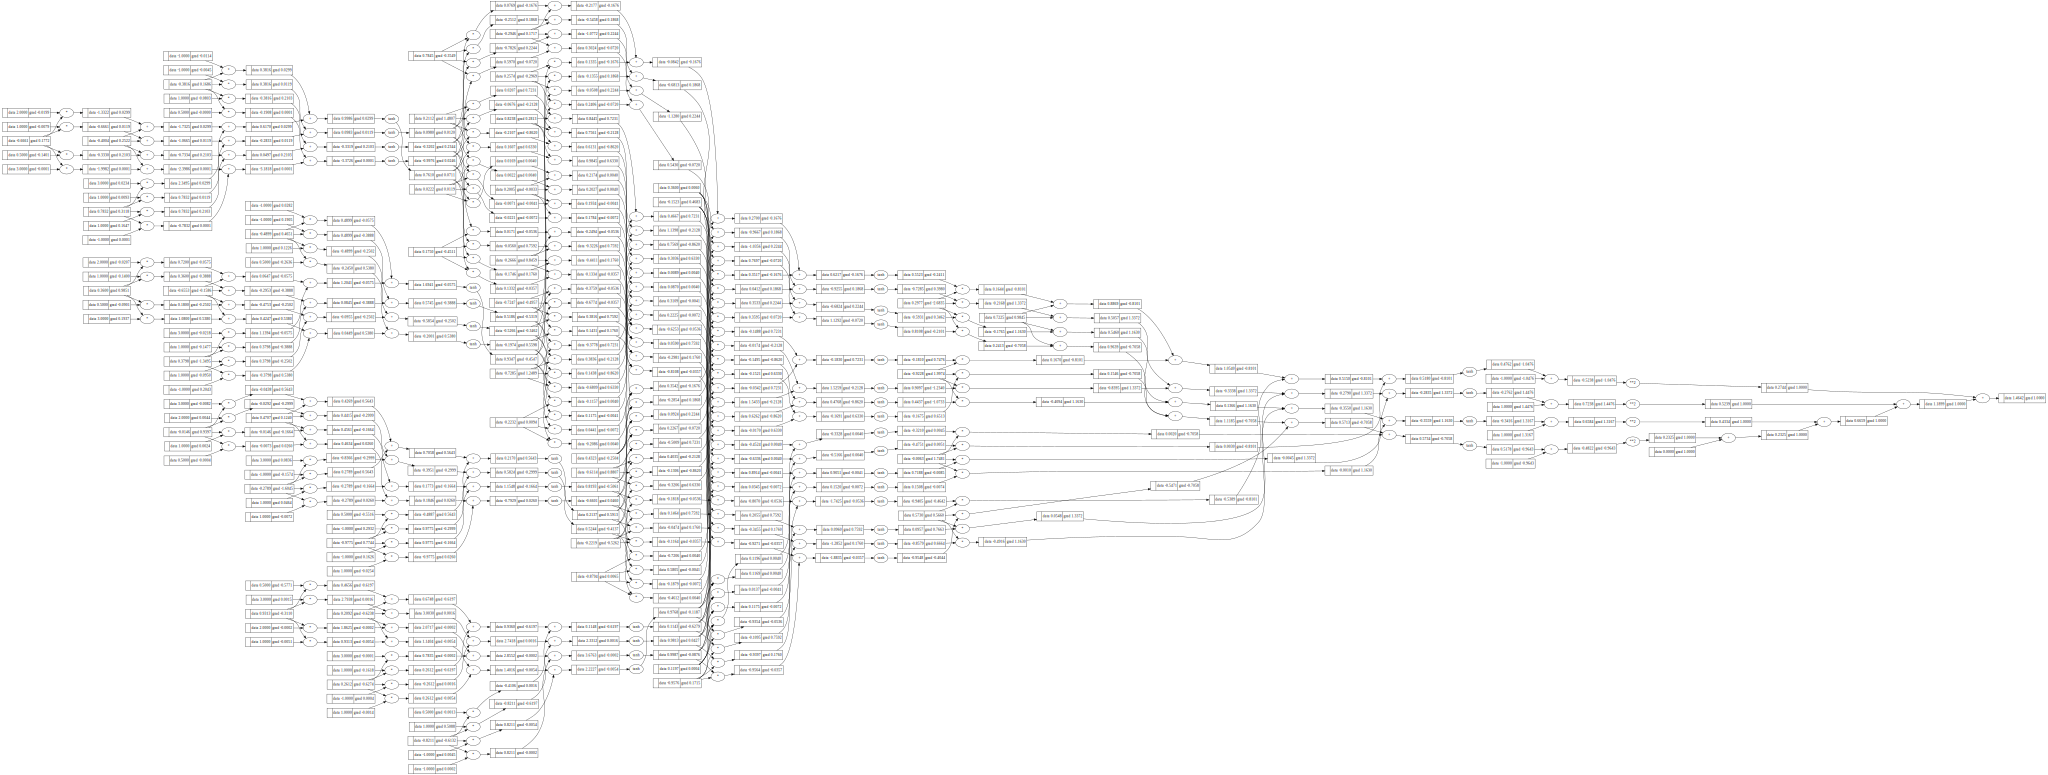

In [ ]:
loss.backward()
draw_dot(loss)

In [ ]:
for k in range(7000):
  # Forward Pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))

  # Backward Pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # Update
  for p in n.parameters():
    p.data += -0.05*p.grad

  print(k,loss.data)

Streaming output truncated to the last 5000 lines.
2000 0.00016069187836239277
2001 0.00016062240328678872
2002 0.00016055298710912578
2003 0.0001604836297551318
2004 0.0001604143311506532
2005 0.00016034509122166105
2006 0.00016027590989426072
2007 0.00016020678709466479
2008 0.00016013772274921595
2009 0.00016006871678438773
2010 0.000159999769126761
2011 0.00015993087970305185
2012 0.0001598620484400967
2013 0.00015979327526484475
2014 0.00015972456010437648
2015 0.00015965590288589165
2016 0.00015958730353671555
2017 0.00015951876198427468
2018 0.00015945027815614723
2019 0.0001593818519800104
2020 0.00015931348338366
2021 0.00015924517229502612
2022 0.00015917691864214946
2023 0.0001591087223531893
2024 0.00015904058335643477
2025 0.00015897250158027342
2026 0.0001589044769532324
2027 0.00015883650940394446
2028 0.0001587685988611697
2029 0.0001587007452537829
2030 0.00015863294851076735
2031 0.00015856520856123924
2032 0.00015849752533442007
2033 0.00015842989875965358
2034 0.000

In [ ]:
ypred

[Value(data=0.9962094220431706),
 Value(data=-0.9983594096669884),
 Value(data=-0.9958880382875898),
 Value(data=0.9959996948833342)]